# 7.1 基于数据集多重抽样的分类器

## 7.1.1 bagging：基于数据随机重抽样的分类器构建方法

## 7.1.2 boosting

# 7.2 训练算法：基于错误提升分类器的性能

$$\varepsilon=\frac{\text{未正确分类的样本数目}}{\text{所有样本数目}}$$

$$\alpha=\frac12\ln\left(\frac{1-\varepsilon}{\varepsilon}\right)$$

$$D_i^{(t+1)} = \frac{D_i^{(t)}\mathrm{e}^{-\alpha}}{\text{Sum}(D)}$$

$$D_i^{(t+1)} = \frac{D_i^{(t)}\mathrm{e}^{\alpha}}{\text{Sum}(D)}$$

# 7.3 基于单层决策树构建弱分类器

In [1]:
from numpy import *

In [2]:
def load_simp_data():
    dat_mat = matrix([[1., 2.1],
                     [2., 1.1],
                     [1.3, 1.],
                     [1., 1.],
                     [2., 1.]])
    class_labels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return dat_mat, class_labels

In [3]:
dat_mat, class_labels = load_simp_data()

**程序清单7-1** 单层决策树生成函数

In [8]:
def stump_classify(data_matrix, dimen, thresh_val, thresh_ineq):
    ret_array = ones((shape(data_matrix)[0], 1))
    if thresh_ineq == 'lt':
        ret_array[data_matrix[:,dimen] <= thresh_val] = -1.0
    else:
        ret_array[data_matrix[:,dimen] > thresh_val] = -1.0
    return ret_array

def build_stump(data_arr, class_labels, D):
    data_matrix = mat(data_arr)
    label_mat = mat(class_labels).T
    m,n = shape(data_matrix)
    num_steps = 10.0
    best_stump = {}
    best_clas_est = mat(zeros((m,1)))
    min_error = inf
    for i in range(n):
        range_min = data_matrix[:,i].min()
        range_max = data_matrix[:,i].max()
        step_size = (range_max-range_min)/num_steps
        for j in range(-1, int(num_steps)+1):
            for inequal in ['lt', 'gt']:
                thresh_val = (range_min + float(j)*step_size)
                predicted_vals = \
                stump_classify(data_matrix, i, thresh_val, inequal)
                err_arr = mat(ones((m,1)))
                err_arr[predicted_vals == label_mat] = 0
                weighted_error = D.T * err_arr
                '''
                print('split: dim {}, thresh {}, thresh inequal: \
                {}, the weighted error is {}'\
                     .format(i, thresh_val, inequal, weighted_error))
                '''
                if weighted_error < min_error:
                    min_error = weighted_error
                    best_clas_est = predicted_vals.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = thresh_val
                    best_stump['ineq'] = inequal
    return best_stump, min_error, best_clas_est

In [9]:
D = mat(ones((5,1))/5)

In [10]:
D

matrix([[ 0.2],
        [ 0.2],
        [ 0.2],
        [ 0.2],
        [ 0.2]])

In [11]:
build_stump(dat_mat, class_labels, D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[ 0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

# 7.4 完整AdaBoost算法的实现

**程序清单7-2** 基于单层决策树的AdaBoost训练过程

In [12]:
def ada_boost_train_DS(data_arr, class_labels, num_it = 40):
    weak_class_arr = []
    m = shape(data_arr)[0]
    D = mat(ones((m,1))/m)
    agg_class_est = mat(zeros((m,1)))
    for i in range(num_it):
        best_stump, error, class_est = build_stump(data_arr, class_labels, D)
        print('D:', D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))
        best_stump['alpha'] = alpha
        weak_class_arr.append(best_stump)
        print('class_est:', class_est.T)
        expon = multiply(-1*alpha*mat(class_labels).T, class_est)
        D = multiply(D, exp(expon))
        D = D/D.sum()
        agg_class_est += alpha * class_est
        print('agg_class_est:', agg_class_est.T)
        agg_errors = multiply(sign(agg_class_est)!=mat(class_labels).T, ones((m,1)))
        error_rate = agg_errors.sum()/m
        print('total error:', error_rate, '\n')
        if error_rate == 0.0:
            break
    return weak_class_arr

In [13]:
classifier_array = ada_boost_train_DS(dat_mat, class_labels, 9)

D: [[ 0.2  0.2  0.2  0.2  0.2]]
class_est: [[-1.  1. -1. -1.  1.]]
agg_class_est: [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error: 0.2 

D: [[ 0.5    0.125  0.125  0.125  0.125]]
class_est: [[ 1.  1. -1. -1. -1.]]
agg_class_est: [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error: 0.2 

D: [[ 0.28571429  0.07142857  0.07142857  0.07142857  0.5       ]]
class_est: [[ 1.  1.  1.  1.  1.]]
agg_class_est: [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error: 0.0 



In [14]:
classifier_array

[{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alpha': 0.8958797346140273,
  'dim': 0,
  'ineq': 'lt',
  'thresh': 0.90000000000000002}]

# 7.5 测试算法：基于AdaBoost的分类

**程序清单7-3** AdaBoost分类函数

In [15]:
def ada_classify(dat_to_class, classifier_arr):
    data_matrix = mat(dat_to_class)
    m = shape(data_matrix)[0]
    agg_class_est = mat(zeros((m,1)))
    for i in range(len(classifier_arr)):
        class_est = stump_classify(data_matrix,
                                  classifier_arr[i]['dim'],
                                  classifier_arr[i]['thresh'],
                                  classifier_arr[i]['ineq'])
        agg_class_est += classifier_arr[i]['alpha'] * class_est
        print(agg_class_est)
    return sign(agg_class_est)

In [16]:
dat_arr, label_arr = load_simp_data()

In [17]:
classifier_arr = ada_boost_train_DS(dat_arr, label_arr, 30)

D: [[ 0.2  0.2  0.2  0.2  0.2]]
class_est: [[-1.  1. -1. -1.  1.]]
agg_class_est: [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error: 0.2 

D: [[ 0.5    0.125  0.125  0.125  0.125]]
class_est: [[ 1.  1. -1. -1. -1.]]
agg_class_est: [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error: 0.2 

D: [[ 0.28571429  0.07142857  0.07142857  0.07142857  0.5       ]]
class_est: [[ 1.  1.  1.  1.  1.]]
agg_class_est: [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error: 0.0 



In [18]:
ada_classify([0, 0], classifier_arr)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [19]:
ada_classify([[5,5],[0,0]], classifier_arr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

# 7.6 示例：在一个难数据集上应用AdaBoost

**程序清单7-4** 自适应数据加载函数

In [20]:
def load_data_set(file_name):
    num_feat = len(open(file_name).readline().split('\t'))
    data_mat = []
    label_mat = []
    fr = open(file_name)
    for line in fr.readlines():
        line_arr = []
        cur_line = line.strip().split('\t')
        for i in range(num_feat - 1):
            line_arr.append(float(cur_line[i]))
        data_mat.append(line_arr)
        label_mat.append(float(cur_line[-1]))
    return data_mat, label_mat    

In [31]:
def ada_boost_train_DS(data_arr, class_labels, num_it = 40):
    weak_class_arr = []
    m = shape(data_arr)[0]
    D = mat(ones((m,1))/m)
    agg_class_est = mat(zeros((m,1)))
    for i in range(num_it):
        best_stump, error, class_est = build_stump(data_arr, class_labels, D)
        # print('D:', D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))
        best_stump['alpha'] = alpha
        weak_class_arr.append(best_stump)
        # print('class_est:', class_est.T)
        expon = multiply(-1*alpha*mat(class_labels).T, class_est)
        D = multiply(D, exp(expon))
        D = D/D.sum()
        agg_class_est += alpha * class_est
        # print('agg_class_est:', agg_class_est.T)
        agg_errors = multiply(sign(agg_class_est)!=mat(class_labels).T, ones((m,1)))
        error_rate = agg_errors.sum()/m
        print('total error:', error_rate)
        if error_rate == 0.0:
            break
    return weak_class_arr

In [32]:
dat_arr, label_arr = load_data_set('horseColicTraining2.txt')

In [33]:
classifier_array = ada_boost_train_DS(dat_arr, label_arr, 10)

total error: 0.284280936455
total error: 0.284280936455
total error: 0.247491638796
total error: 0.247491638796
total error: 0.254180602007
total error: 0.240802675585
total error: 0.240802675585
total error: 0.220735785953
total error: 0.247491638796
total error: 0.230769230769


In [34]:
test_arr, test_label_arr = load_data_set('horseColicTest2.txt')

In [35]:
prediction10 = ada_classify(test_arr, classifier_array)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

In [36]:
err_arr = mat(ones((67,1)))

In [37]:
err_arr[prediction10!=mat(test_label_arr).T].sum()

16.0

# 7.7 非均衡分类问题

## 7.7.1 其他分类性能度量指标：正确率、召回率及ROC曲线

$$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$$

$$\text{Recall}=\frac{\text{TP}}{\text{TP}+\text{FN}}$$

**程序清单7-5** ROC曲线的绘制及AUC计算函数

In [38]:
%matplotlib inline

In [40]:
def plot_ROC(pred_strengths, class_labels):
    import matplotlib.pyplot as plt
    cur = (1.0, 1.0)
    y_sum = 0.0
    num_pos_class = sum(array(class_labels)==1.0)
    y_step = 1/float(num_pos_class)
    x_step = 1/float(len(class_labels)-num_pos_class)
    sorted_indices = pred_strengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sorted_indices.tolist()[0]:
        if class_labels[index] == 1.0:
            del_x = 0
            del_y = y_step
        else:
            del_x = x_step
            del_y = 0
            y_sum += cur[1]
        ax.plot([cur[0],cur[0]-del_x],[cur[1],cur[1]-del_y],c='b')
        cur = (cur[0]-del_x, cur[1]-del_y)
    ax.plot([0,1], [0,1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print('The Area Under the Curve is:', y_sum * x_step)

In [41]:
def ada_boost_train_DS(data_arr, class_labels, num_it = 40):
    weak_class_arr = []
    m = shape(data_arr)[0]
    D = mat(ones((m,1))/m)
    agg_class_est = mat(zeros((m,1)))
    for i in range(num_it):
        best_stump, error, class_est = build_stump(data_arr, class_labels, D)
        # print('D:', D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))
        best_stump['alpha'] = alpha
        weak_class_arr.append(best_stump)
        # print('class_est:', class_est.T)
        expon = multiply(-1*alpha*mat(class_labels).T, class_est)
        D = multiply(D, exp(expon))
        D = D/D.sum()
        agg_class_est += alpha * class_est
        # print('agg_class_est:', agg_class_est.T)
        agg_errors = multiply(sign(agg_class_est)!=mat(class_labels).T, ones((m,1)))
        error_rate = agg_errors.sum()/m
        print('total error:', error_rate)
        if error_rate == 0.0:
            break
    return weak_class_arr, agg_class_est

In [42]:
dat_arr, label_arr = load_data_set('horseColicTraining2.txt')

In [43]:
classifier_array, agg_class_est = ada_boost_train_DS(dat_arr, label_arr, 10)

total error: 0.284280936455
total error: 0.284280936455
total error: 0.247491638796
total error: 0.247491638796
total error: 0.254180602007
total error: 0.240802675585
total error: 0.240802675585
total error: 0.220735785953
total error: 0.247491638796
total error: 0.230769230769


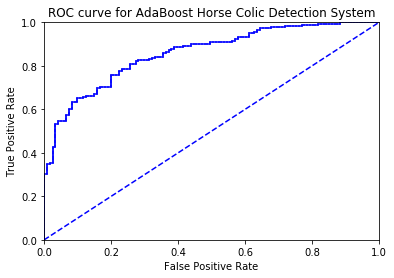

The Area Under the Curve is: 0.8582969635063604


In [45]:
plot_ROC(agg_class_est.T, label_arr)

## 7.7.2 基于代价函数的分类器决策控制

## 7.7.3 处理非均衡问题的数据抽样方法

# 7.8 本章小结